# Brent Monthly Oil Price Forecast with LSTM and TimeseriesGenerator

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from keras.utils.vis_utils import plot_model
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Data reading and preparing

In [2]:
df = pd.read_excel(io='https://www.eia.gov/dnav/pet/hist_xls/RBRTEm.xls', sheet_name='Data 1', skiprows = 2)
df = df.rename({'Europe Brent Spot Price FOB (Dollars per Barrel)': 'Price'}, axis='columns')
df.shape

(420, 2)

In [3]:
df = df.set_index(['Date'])
df.tail()

,Price
Date,
2021-12-15,74.17
2022-01-15,86.51
2022-02-15,97.13
2022-03-15,117.25
2022-04-15,104.58


In [4]:
train = df
scaler = MinMaxScaler()
scaler.fit(train)
train = scaler.transform(train)

## Model training

In [5]:
epochs = 200
learning_rate = 0.00005
n_input = 12
n_features = 1
generator = TimeseriesGenerator(train, train, length = n_input, batch_size = 6)

In [6]:
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(200, activation='relu', input_shape = (n_input, n_features)))
    model.add(Dropout(0.15))
    model.add(Dense(1))
    optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
    model.compile(optimizer = optimizer, loss='mse')
    return model

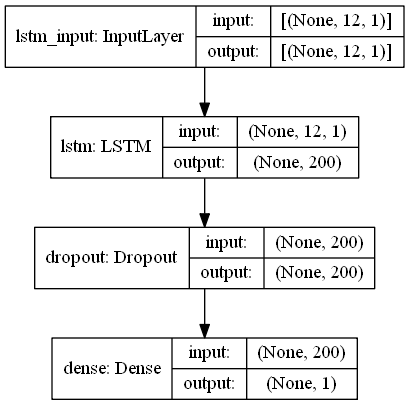

In [7]:
model = build_lstm_model()
plot_model(model, to_file = 'lstm_model_plot.png', show_shapes = True, show_layer_names = True)

In [8]:
history = model.fit_generator(generator, epochs = epochs, verbose = 1)

Epoch 1/200
68/68 [==============================] - 1s 4ms/step - loss: 0.1342
Epoch 2/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0975
Epoch 3/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0569
Epoch 4/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0238
Epoch 5/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0144
Epoch 6/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0125
Epoch 7/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0110
Epoch 8/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0102
Epoch 9/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0101
Epoch 10/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0101
Epoch 11/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0101
Epoch 12/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0103
Epoch 13/200
68/68 [=================

68/68 [==============================] - 0s 4ms/step - loss: 0.0056
Epoch 103/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0057
Epoch 104/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0058
Epoch 105/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0060
Epoch 106/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0055
Epoch 107/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0062
Epoch 108/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0054
Epoch 109/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0060
Epoch 110/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0055
Epoch 111/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0060
Epoch 112/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0056
Epoch 113/200
68/68 [==============================] - 0s 4ms/step - loss: 0.0058
Epoch 114/200
68/68 [=========

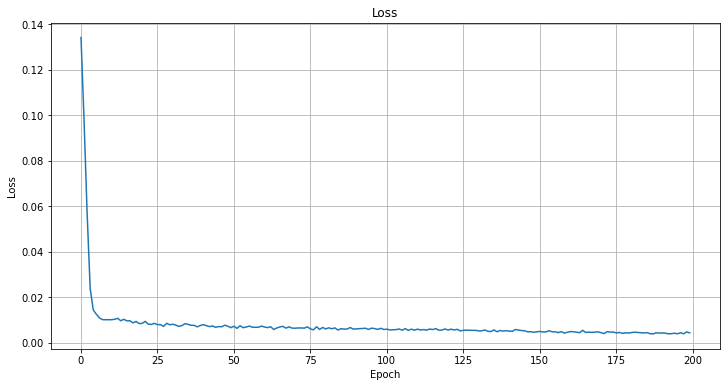

In [9]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
plt.figure(figsize=(12, 6))
plt.plot(hist['epoch'], hist['loss']) 
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid(True)
plt.show()

## Prediction

In [10]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):   
    pred_list.append(model.predict(batch)[0]) 
    batch = np.append(batch[:,1:,:], [[pred_list[i]]], axis = 1)

In [11]:
add_dates = [df.index[-1] + DateOffset(months = x) for x in range(0, n_input + 1) ]
future_dates = pd.DataFrame(index=add_dates[1:], columns = df.columns)

In [12]:
df_predict = pd.DataFrame(scaler.inverse_transform(pred_list), index = future_dates[-n_input:].index, columns=['Prediction'])
df_proj = pd.concat([df,df_predict], axis=1)
df_proj.tail(n_input)

,Price,Prediction
2022-05-15,NaN,105.918409
2022-06-15,NaN,107.985465
2022-07-15,NaN,108.663072
2022-08-15,NaN,109.278883
2022-09-15,NaN,109.592879
2022-10-15,NaN,109.505326
2022-11-15,NaN,109.481782
2022-12-15,NaN,109.299812
2023-01-15,NaN,109.131217
2023-02-15,NaN,108.990716


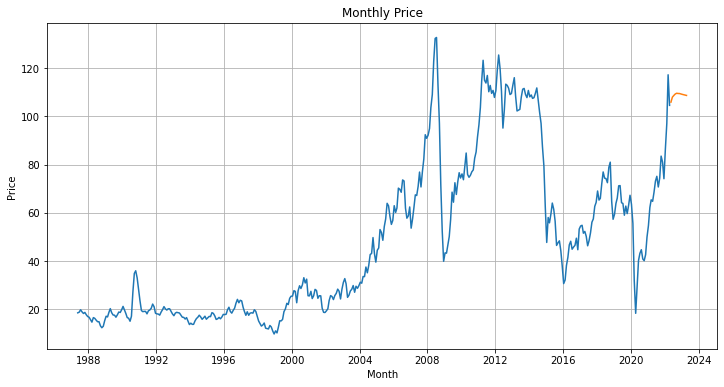

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(df_proj.index, df_proj['Price'])
plt.plot(df_proj.index, df_proj['Prediction']) 
plt.xlabel('Month')
plt.ylabel('Price')
#plt.xscale('log')
plt.title('Monthly Price')
plt.grid(True)
plt.show()